In [1]:
from dotenv import load_dotenv
import os

load_dotenv()

True

In [3]:
from entsoe import EntsoePandasClient
import pandas as pd

entsoe_client = EntsoePandasClient(api_key=os.getenv('ENTSOE_API_KEY'))

df = entsoe_client.query_load_and_forecast(
    country_code="CH", 
    start=pd.Timestamp('2013-01-01 00:00', tz="Europe/Zurich"), 
    end=pd.Timestamp('2025-01-01 00:00', tz="Europe/Zurich"),
)
df.head(5)

,Forecasted Load,Actual Load
2014-10-24 00:00:00+02:00,NaN,6522.0
2014-10-24 01:00:00+02:00,NaN,6342.0
2014-10-24 02:00:00+02:00,NaN,6269.0
2014-10-24 03:00:00+02:00,NaN,6230.0
2014-10-24 04:00:00+02:00,NaN,6257.0


In [4]:
df_ = df.copy()

In [24]:
df = df_.copy()

# Wrangling

In [95]:
df = df_.copy()[['Actual Load']]

In [96]:
from datetime import timedelta

df = df.set_index(df.index - timedelta(hours=24))
df = df.rename(columns={'Actual Load': '24h_later_load'})
df.head()

,24h_later_load
2014-10-23 00:00:00+02:00,6522.0
2014-10-23 01:00:00+02:00,6342.0
2014-10-23 02:00:00+02:00,6269.0
2014-10-23 03:00:00+02:00,6230.0
2014-10-23 04:00:00+02:00,6257.0


# Dummy baseline

In [97]:
from datetime import timedelta
import plotly.express as px
from sklearn.metrics import mean_absolute_percentage_error

# Enrich the data with the 24h_ago_load
df = df.asfreq('h') # Enforce an hourly frequency
df['24h_ago_load'] = df['24h_later_load'].shift(48)

# Only consider the last year
with_load_latest_ts = df[~df['24h_later_load'].isna()].index.max() 
df = df[df.index >= with_load_latest_ts - timedelta(days=365)]

# Build y_true and y_pred
df = df.dropna()
y_true = df['24h_later_load']
y_pred = df['24h_ago_load']
print(f'MAPE over the last year: {mean_absolute_percentage_error(y_true, y_pred) * 100:.2f}%') 
# MAPE over the last year: 8.97%

# Plot the last month
df = df[df.index >= df.index.max() - timedelta(days=30)]

fig = px.line(
    df, x=df.index, y=['24h_later_load', '24h_ago_load'], 
    title='Actual load and dummy forecast over the last month',
    labels={'index': 'Date', 'value': 'Load [MW]', 'variable': ''}
)

fig.for_each_trace(lambda t: t.update(name={'24h_later_load': 'Actual load', '24h_ago_load': 'Dummy forecast'}[t.name]));

MAPE over the last year: 8.97%


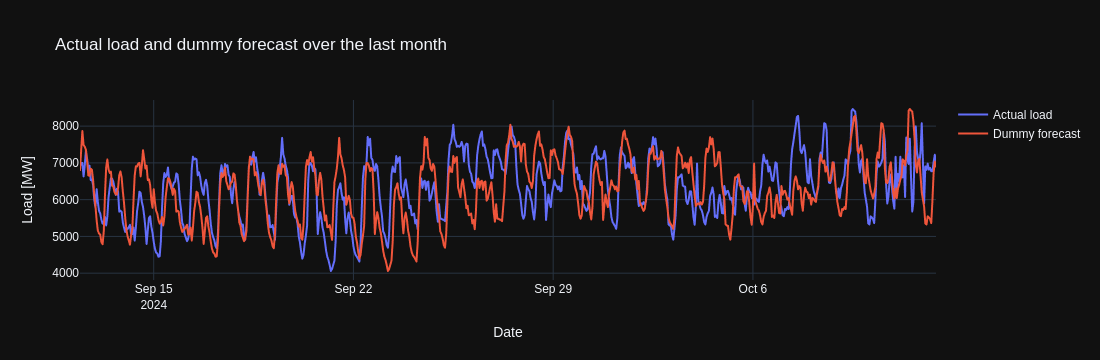

In [98]:
fig.layout.template = "plotly_dark"
fig.show()

In [99]:
fig.write_html("dummy_forecast_lineplot.html", include_plotlyjs='cdn')

# Naive LightGBM

In [342]:
df = df_.copy()[['Actual Load']]

In [343]:
from datetime import timedelta

df = df.set_index(df.index - timedelta(hours=24))
df = df.rename(columns={'Actual Load': '24h_later_load'})
df.head()

,24h_later_load
2014-10-23 00:00:00+02:00,6522.0
2014-10-23 01:00:00+02:00,6342.0
2014-10-23 02:00:00+02:00,6269.0
2014-10-23 03:00:00+02:00,6230.0
2014-10-23 04:00:00+02:00,6257.0


In [344]:
# Enrich the data with the 24h_ago_load
df = df.asfreq('h') # Enforce an hourly frequency
df['24h_ago_load'] = df['24h_later_load'].shift(48)
df.head(3)

,24h_later_load,24h_ago_load
2014-10-23 00:00:00+02:00,6522.0,NaN
2014-10-23 01:00:00+02:00,6342.0,NaN
2014-10-23 02:00:00+02:00,6269.0,NaN


In [345]:
import lightgbm as lgb
import pandas as pd

def train_predict(model: lgb.LGBMRegressor, Xy: pd.DataFrame, query_ts: pd.Timestamp) -> float:
    # Extract the testing X
    if not query_ts in Xy.index:
        raise ValueError(f"Query timestamp {query_ts} is missing from Xy's index.")
    X_test = Xy.loc[[query_ts]].drop(columns=["24h_later_load"])

    # Prepare training data
    Xy = Xy.dropna(subset=("24h_later_load"))
    Xy_train = Xy[Xy.index < query_ts]  # Only train on data strictly before the ts
    X_train, y_train = Xy_train.drop(columns=["24h_later_load"]), Xy_train["24h_later_load"]

    # Train the model
    model.fit(X_train, y_train)

    # Predict
    return float(model.predict(X_test)[0])

In [ ]:
# THIS CELL IS ONLY HERE TO SHOW THAT IT'S UNREASONABLE TO RUN
from tqdm import tqdm
from sklearn.metrics import mean_absolute_percentage_error

# Figure out all timestamps within the last year
with_load_latest_ts = df[~df['24h_later_load'].isna()].index.max() 
mask = (df.index <= with_load_latest_ts) & (df.index >= with_load_latest_ts - timedelta(days=365)) 
timestamps = df[mask].dropna(subset=('24h_later_load')).index.tolist()

# For each timestamp, train a model and use it to predict the target
reg = lgb.LGBMRegressor(n_estimators=10_000, force_row_wise=True, verbose=0)
ts_to_predicted_value = {}
for ts in tqdm(timestamps):
    ts_to_predicted_value[ts] = train_predict(model=reg, Xy=df, query_ts=ts)

# Shape up the predictions into a Dataframe
y_pred = pd.DataFrame(
    {"predicted_24h_later_load": ts_to_predicted_value.values()},
    index=pd.DatetimeIndex(ts_to_predicted_value.keys()),
) 

In [347]:
from tqdm import tqdm
from sklearn.metrics import mean_absolute_percentage_error
from random import sample

# Figure out all timestamps within the last year
with_load_latest_ts = df[~df['24h_later_load'].isna()].index.max() 
mask = (df.index <= with_load_latest_ts) & (df.index >= with_load_latest_ts - timedelta(days=365)) 
timestamps = df[mask].dropna(subset=('24h_later_load')).index.tolist()

# Subsample to only train 100 models
# timestamps = sample(timestamps, k=100)

# For each timestamp, train a model and use it to predict the target
reg = lgb.LGBMRegressor(n_estimators=1, force_row_wise=True, verbose=0)
ts_to_predicted_value = {}
for ts in tqdm(timestamps):
    ts_to_predicted_value[ts] = train_predict(model=reg, Xy=df, query_ts=ts)

# Shape up the predictions into a Dataframe
y_pred = pd.DataFrame(
    {"predicted_24h_later_load": ts_to_predicted_value.values()},
    index=pd.DatetimeIndex(ts_to_predicted_value.keys()),
)

100%|██████████| 8760/8760 [03:55<00:00, 37.27it/s]


In [381]:
import numpy as np

# Get randomly-ordered timestamps to study the MAPE
random_timestamps = y_pred.index.tolist()
np.random.shuffle(random_timestamps) 

# Package the y_pred and y_true into a dataframe
y_true = df.loc[y_pred.index, ['24h_later_load']]
y_df = pd.concat([y_true, y_pred], axis=1)
y_df['APE'] = y_df.apply(lambda row: 100 * abs(row['24h_later_load'] - row['predicted_24h_later_load']) / row['24h_later_load'], axis=1)

# For each discarded proportion, compute the MAPE
discarded_proportion_to_mape = {}
for i in tqdm(range(len(random_timestamps))):
    discarded_proportion = i / len(random_timestamps) * 100
    discarded_proportion_to_mape[discarded_proportion] = y_df.loc[random_timestamps[i:], 'APE'].mean()

mape_df = pd.DataFrame({
    'discarded_proportion': discarded_proportion_to_mape.keys(),
    'estimated_MAPE': discarded_proportion_to_mape.values(),
})

100%|██████████| 8760/8760 [04:41<00:00, 31.11it/s]


In [398]:
# Plot
fig = px.line(
    mape_df, x='discarded_proportion', y='estimated_MAPE', 
    title='Evolution of the yearly-MAPE <br>when discarding some proportion of the timestamps making up the year',
    labels={'discarded_proportion': 'Proportion of discarded timestamps [%]', 'estimated_MAPE': 'Estimated MAPE [%] over the last year'}
)

fig.add_hline(y=mape_df.loc[0].estimated_MAPE, line_dash="dot",
              annotation_text="Actual MAPE", 
              annotation_position="bottom right");

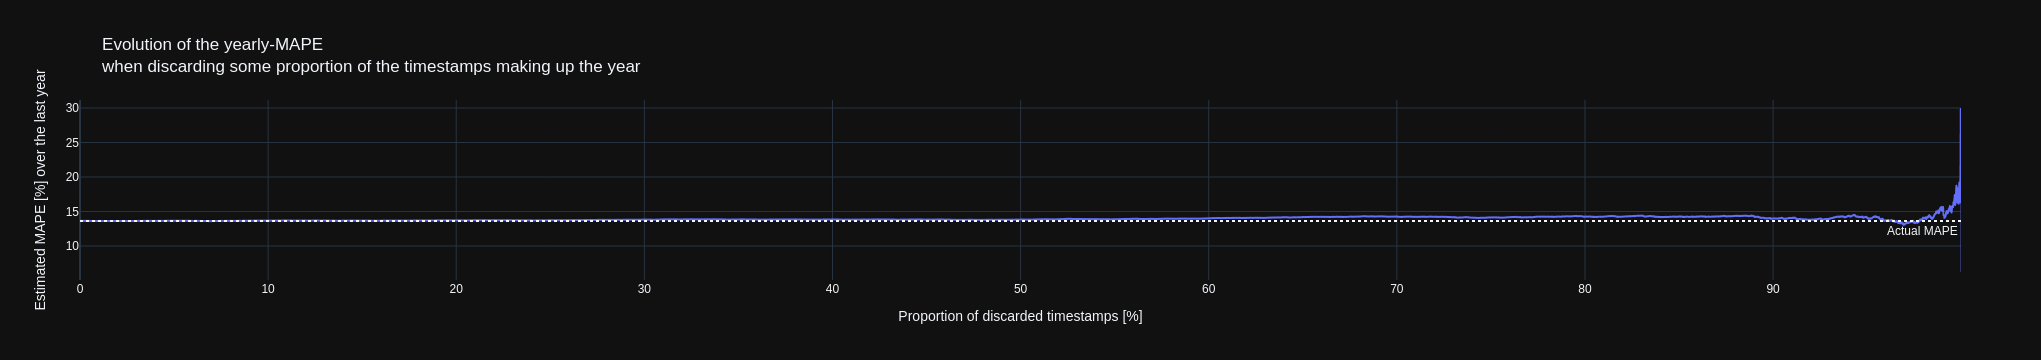

In [396]:
fig.layout.template = "plotly_dark"
fig.show()

In [397]:
fig.write_html("mape_degradation_study.html", include_plotlyjs='cdn')

In [401]:
from tqdm import tqdm
from sklearn.metrics import mean_absolute_percentage_error
from random import sample

# Figure out all timestamps within the last year
with_load_latest_ts = df[~df['24h_later_load'].isna()].index.max() 
mask = (df.index <= with_load_latest_ts) & (df.index >= with_load_latest_ts - timedelta(days=365)) 
timestamps = df[mask].dropna(subset=('24h_later_load')).index.tolist()

# Subsample to only train 100 models
timestamps = sample(timestamps, k=len(timestamps) // 100)

# For each timestamp, train a model and use it to predict the target
reg = lgb.LGBMRegressor(n_estimators=10_000, force_row_wise=True, verbose=0)
ts_to_predicted_value = {}
for ts in tqdm(timestamps):
    ts_to_predicted_value[ts] = train_predict(model=reg, Xy=df, query_ts=ts)

# Shape up the predictions into a Dataframe
y_pred = pd.DataFrame(
    {"predicted_24h_later_load": ts_to_predicted_value.values()},
    index=pd.DatetimeIndex(ts_to_predicted_value.keys()),
)

# Compute the estimated MAPE
y_true = df.loc[y_pred.index, ['24h_later_load']]
print(f'Estimated yearly-MAPE [%]: {mean_absolute_percentage_error(y_true, y_pred) * 100:.2f}')
# Estimated yearly-MAPE [%]: 8.47

100%|██████████████| 87/87 [19:27<00:00, 13.42s/it]


# LGBM w/ past loads 

In [412]:
df = df_.copy()[['Actual Load']]

In [413]:
from datetime import timedelta

df = df.set_index(df.index - timedelta(hours=24))
df = df.rename(columns={'Actual Load': '24h_later_load'})
df.head()

,24h_later_load
2014-10-23 00:00:00+02:00,6522.0
2014-10-23 01:00:00+02:00,6342.0
2014-10-23 02:00:00+02:00,6269.0
2014-10-23 03:00:00+02:00,6230.0
2014-10-23 04:00:00+02:00,6257.0


In [414]:
# Enrich the data with the 24h_ago_load
df = df.asfreq('h') # Enforce an hourly frequency
df['24h_ago_load'] = df['24h_later_load'].shift(48)
df.head(3)

,24h_later_load,24h_ago_load
2014-10-23 00:00:00+02:00,6522.0,NaN
2014-10-23 01:00:00+02:00,6342.0,NaN
2014-10-23 02:00:00+02:00,6269.0,NaN


In [415]:
# Enrich the data w/ more past loads
df['1h_ago_load'] = df['24h_later_load'].shift(24 + 1)
df['2h_ago_load'] = df['24h_later_load'].shift(24 + 2)
df['3h_ago_load'] = df['24h_later_load'].shift(24 + 3)
df['7d_ago_load'] = df['24h_later_load'].shift(24 + 24*7)
df.head(3)

,24h_later_load,24h_ago_load,1h_ago_load,2h_ago_load,3h_ago_load,7d_ago_load
2014-10-23 00:00:00+02:00,6522.0,NaN,NaN,NaN,NaN,NaN
2014-10-23 01:00:00+02:00,6342.0,NaN,NaN,NaN,NaN,NaN
2014-10-23 02:00:00+02:00,6269.0,NaN,NaN,NaN,NaN,NaN


In [417]:
from tqdm import tqdm
from sklearn.metrics import mean_absolute_percentage_error
from random import sample

# Figure out all timestamps within the last year
with_load_latest_ts = df[~df['24h_later_load'].isna()].index.max() 
mask = (df.index <= with_load_latest_ts) & (df.index >= with_load_latest_ts - timedelta(days=365)) 
timestamps = df[mask].dropna(subset=('24h_later_load')).index.tolist()

# Subsample to only train 100 models
timestamps = sample(timestamps, k=len(timestamps) // 100)

# For each timestamp, train a model and use it to predict the target
reg = lgb.LGBMRegressor(n_estimators=10_000, force_row_wise=True, verbose=0)
ts_to_predicted_value = {}
for ts in tqdm(timestamps):
    ts_to_predicted_value[ts] = train_predict(model=reg, Xy=df, query_ts=ts)

# Shape up the predictions into a Dataframe
y_pred = pd.DataFrame(
    {"predicted_24h_later_load": ts_to_predicted_value.values()},
    index=pd.DatetimeIndex(ts_to_predicted_value.keys()),
)

# Compute the estimated MAPE
y_true = df.loc[y_pred.index, ['24h_later_load']]
print(f'Estimated yearly-MAPE [%]: {mean_absolute_percentage_error(y_true, y_pred) * 100:.2f}')
# Estimated yearly-MAPE [%]: 7.98

100%|██████████████| 87/87 [16:11<00:00, 11.16s/it]

Estimated yearly-MAPE [%]: 7.98


# LGBM w/ past loads & time attributes 

In [418]:
df = df_.copy()[['Actual Load']]

In [419]:
from datetime import timedelta

df = df.set_index(df.index - timedelta(hours=24))
df = df.rename(columns={'Actual Load': '24h_later_load'})
df.head()

,24h_later_load
2014-10-23 00:00:00+02:00,6522.0
2014-10-23 01:00:00+02:00,6342.0
2014-10-23 02:00:00+02:00,6269.0
2014-10-23 03:00:00+02:00,6230.0
2014-10-23 04:00:00+02:00,6257.0


In [420]:
# Enrich the data with the 24h_ago_load
df = df.asfreq('h') # Enforce an hourly frequency
df['24h_ago_load'] = df['24h_later_load'].shift(48)
df.head(3)

,24h_later_load,24h_ago_load
2014-10-23 00:00:00+02:00,6522.0,NaN
2014-10-23 01:00:00+02:00,6342.0,NaN
2014-10-23 02:00:00+02:00,6269.0,NaN


In [421]:
# Enrich the data w/ more past loads
df['1h_ago_load'] = df['24h_later_load'].shift(24 + 1)
df['2h_ago_load'] = df['24h_later_load'].shift(24 + 2)
df['3h_ago_load'] = df['24h_later_load'].shift(24 + 3)
df['7d_ago_load'] = df['24h_later_load'].shift(24 + 24*7)
df.head(3)

,24h_later_load,24h_ago_load,1h_ago_load,2h_ago_load,3h_ago_load,7d_ago_load
2014-10-23 00:00:00+02:00,6522.0,NaN,NaN,NaN,NaN,NaN
2014-10-23 01:00:00+02:00,6342.0,NaN,NaN,NaN,NaN,NaN
2014-10-23 02:00:00+02:00,6269.0,NaN,NaN,NaN,NaN,NaN


In [422]:
# Enrich the df with the datetime attributes
df['month'] = df.index.month
df['day'] = df.index.day
df['hour'] = df.index.hour
df['weekday'] = df.index.weekday
df.head(3)

,24h_later_load,24h_ago_load,1h_ago_load,2h_ago_load,3h_ago_load,7d_ago_load,month,day,hour,weekday
2014-10-23 00:00:00+02:00,6522.0,NaN,NaN,NaN,NaN,NaN,10,23,0,3
2014-10-23 01:00:00+02:00,6342.0,NaN,NaN,NaN,NaN,NaN,10,23,1,3
2014-10-23 02:00:00+02:00,6269.0,NaN,NaN,NaN,NaN,NaN,10,23,2,3


In [424]:
from tqdm import tqdm
from sklearn.metrics import mean_absolute_percentage_error
from random import sample

# Figure out all timestamps within the last year
with_load_latest_ts = df[~df['24h_later_load'].isna()].index.max() 
mask = (df.index <= with_load_latest_ts) & (df.index >= with_load_latest_ts - timedelta(days=365)) 
timestamps = df[mask].dropna(subset=('24h_later_load')).index.tolist()

# Subsample to only train 100 models
timestamps = sample(timestamps, k=len(timestamps) // 100)

# For each timestamp, train a model and use it to predict the target
reg = lgb.LGBMRegressor(n_estimators=10_000, force_row_wise=True, verbose=0)
ts_to_predicted_value = {}
for ts in tqdm(timestamps):
    ts_to_predicted_value[ts] = train_predict(model=reg, Xy=df, query_ts=ts)

# Shape up the predictions into a Dataframe
y_pred = pd.DataFrame(
    {"predicted_24h_later_load": ts_to_predicted_value.values()},
    index=pd.DatetimeIndex(ts_to_predicted_value.keys()),
)

# Compute the estimated MAPE
y_true = df.loc[y_pred.index, ['24h_later_load']]
print(f'Estimated yearly-MAPE [%]: {mean_absolute_percentage_error(y_true, y_pred) * 100:.2f}')
# Estimated yearly-MAPE [%]: 5.40

100%|██████████████| 87/87 [20:50<00:00, 14.38s/it]

Estimated yearly-MAPE [%]: 5.40


# LGBM w/ past loads & time attributes & load statistics

In [425]:
df = df_.copy()[['Actual Load']]

In [426]:
from datetime import timedelta

df = df.set_index(df.index - timedelta(hours=24))
df = df.rename(columns={'Actual Load': '24h_later_load'})
df.head()

,24h_later_load
2014-10-23 00:00:00+02:00,6522.0
2014-10-23 01:00:00+02:00,6342.0
2014-10-23 02:00:00+02:00,6269.0
2014-10-23 03:00:00+02:00,6230.0
2014-10-23 04:00:00+02:00,6257.0


In [427]:
# Enrich the data with the 24h_ago_load
df = df.asfreq('h') # Enforce an hourly frequency
df['24h_ago_load'] = df['24h_later_load'].shift(48)
df.head(3)

,24h_later_load,24h_ago_load
2014-10-23 00:00:00+02:00,6522.0,NaN
2014-10-23 01:00:00+02:00,6342.0,NaN
2014-10-23 02:00:00+02:00,6269.0,NaN


In [428]:
# Enrich the data w/ more past loads
df['1h_ago_load'] = df['24h_later_load'].shift(24 + 1)
df['2h_ago_load'] = df['24h_later_load'].shift(24 + 2)
df['3h_ago_load'] = df['24h_later_load'].shift(24 + 3)
df['7d_ago_load'] = df['24h_later_load'].shift(24 + 24*7)
df.head(3)

,24h_later_load,24h_ago_load,1h_ago_load,2h_ago_load,3h_ago_load,7d_ago_load
2014-10-23 00:00:00+02:00,6522.0,NaN,NaN,NaN,NaN,NaN
2014-10-23 01:00:00+02:00,6342.0,NaN,NaN,NaN,NaN,NaN
2014-10-23 02:00:00+02:00,6269.0,NaN,NaN,NaN,NaN,NaN


In [429]:
# Enrich the df with the datetime attributes
df['month'] = df.index.month
df['day'] = df.index.day
df['hour'] = df.index.hour
df['weekday'] = df.index.weekday
df.head(3)

,24h_later_load,24h_ago_load,1h_ago_load,2h_ago_load,3h_ago_load,7d_ago_load,month,day,hour,weekday
2014-10-23 00:00:00+02:00,6522.0,NaN,NaN,NaN,NaN,NaN,10,23,0,3
2014-10-23 01:00:00+02:00,6342.0,NaN,NaN,NaN,NaN,NaN,10,23,1,3
2014-10-23 02:00:00+02:00,6269.0,NaN,NaN,NaN,NaN,NaN,10,23,2,3


In [439]:
# Compute statistics over the past 8h
df['8h_min'] = df['1h_ago_load'].rolling(window=8, min_periods=1).apply(np.nanmin)
df['8h_max'] = df['1h_ago_load'].rolling(window=8, min_periods=1).apply(np.nanmax)
df['8h_median'] = df['1h_ago_load'].rolling(window=8, min_periods=1).apply(np.nanmedian)

# Compute statistics over the past 24h
df['24h_min'] = df['1h_ago_load'].rolling(window=24, min_periods=1).apply(np.nanmin)
df['24h_max'] = df['1h_ago_load'].rolling(window=24, min_periods=1).apply(np.nanmax)
df['24h_median'] = df['1h_ago_load'].rolling(window=24, min_periods=1).apply(np.nanmedian)

# Compute statistics over the past 7d
df['7d_min'] = df['1h_ago_load'].rolling(window=24*7, min_periods=1).apply(np.nanmin)
df['7d_max'] = df['1h_ago_load'].rolling(window=24*7, min_periods=1).apply(np.nanmax)
df['7d_median'] = df['1h_ago_load'].rolling(window=24*7, min_periods=1).apply(np.nanmedian)

In [440]:
from tqdm import tqdm
from sklearn.metrics import mean_absolute_percentage_error
from random import sample

# Figure out all timestamps within the last year
with_load_latest_ts = df[~df['24h_later_load'].isna()].index.max() 
mask = (df.index <= with_load_latest_ts) & (df.index >= with_load_latest_ts - timedelta(days=365)) 
timestamps = df[mask].dropna(subset=('24h_later_load')).index.tolist()

# Subsample to only train 100 models
timestamps = sample(timestamps, k=len(timestamps) // 100)

# For each timestamp, train a model and use it to predict the target
reg = lgb.LGBMRegressor(n_estimators=10_000, force_row_wise=True, verbose=0)
ts_to_predicted_value = {}
for ts in tqdm(timestamps):
    ts_to_predicted_value[ts] = train_predict(model=reg, Xy=df, query_ts=ts)

# Shape up the predictions into a Dataframe
y_pred = pd.DataFrame(
    {"predicted_24h_later_load": ts_to_predicted_value.values()},
    index=pd.DatetimeIndex(ts_to_predicted_value.keys()),
)

# Compute the estimated MAPE
y_true = df.loc[y_pred.index, ['24h_later_load']]
print(f'Estimated yearly-MAPE [%]: {mean_absolute_percentage_error(y_true, y_pred) * 100:.2f}')
# Estimated yearly-MAPE [%]: 4.11

100%|██████████████| 87/87 [25:57<00:00, 17.91s/it]

Estimated yearly-MAPE [%]: 4.11
